In [1]:
# We use the sympy Python library to work with symbolic expressions
import sympy as sp

# Transform is needed to round the coefficients to 2 decimal places
from sympy.core.rules import Transform

# Import the modules to construct and represent the fields
import numpy as np
import matplotlib.pyplot as plt

# Sympy's latex printing
sp.init_printing(use_latex = True)

## A Rational Map in the Skyrme model maps the radial and stereographic coordinates $r, z(\theta, \phi), \bar{z}(\theta, \phi)$ of the base space to the coordinates of the target space (the Skyrme fields)

$U := \exp{\{f(r) \vec{n_R} \vec{\tau}\}} = \cos(f(r)) I_2 + \sin(f(r))\vec{n}_R \vec{\tau}$,

$\vec{n}_R = \frac{1}{1+|R(z)|^2}(2\Re(R(z)), 2\Im(R(z)), 1-|R(z)|^2)$,

$R(z) = \frac{p(z)}{q(z)}$

$z = \tg(\theta/2)\exp{\{i \phi\}}$

In [2]:
# Define the real and imaginary parts of the stereographic coordinate z
zRe = sp.Symbol('Re_z', real = True)
zIm = sp.Symbol('Im_z', real = True)

z = zRe + sp.I*zIm

z

In [3]:
# The complex conjugate of z
z.conjugate()

In [4]:
# Split between real and imaginary parts
sp.re(z), sp.im(z)

In [5]:
# Rounding function up to 2 decimal places
def RoundExpr(expr):
    new_expr = expr.xreplace(Transform(lambda x: x.round(2), lambda x: isinstance(x, sp.Float)))
    return new_expr

In [6]:
# Extract the Real and Imaginary parts of the Rational Map
def RationalMap_Parts(Rmap_Num, Rmap_Den):
    Denom = sp.simplify(sp.expand(sp.expand(Rmap_Den)*sp.expand(Rmap_Den.conjugate())))
    Numer = sp.simplify(sp.expand(sp.expand(Rmap_Num)*sp.expand(Rmap_Den.conjugate())))
    R_Re = sp.re(Numer)
    R_Im = sp.im(Numer)
    return RoundExpr(Denom), RoundExpr(R_Re), RoundExpr(R_Im)

In [7]:
# Parameters to construct the Skyrme fields
Nfields = 4
Ndims = 3

dx = 0.2
N = 101
xmax = (N-1)*dx/2
x = np.arange(-xmax, xmax+dx, dx)

c0 = 0 # c0 = 2*mpi**2/(fpi*e)**2
c6 = 0 # c6 = 2*lambda**2*fpi**2*e**4

In [8]:
# Levi-Civita symbol
def LeviCivita(a,b,c,d):
    return (a-b)*(a-c)*(a-d)*(b-c)*(b-d)*(c-d)/12.

# Derivatives
def D(phi):
    # dphi[a][i] = d_i n_a
    dphi = np.zeros((Nfields, Ndims, N-4, N-4, N-4))
    for a in range(Nfields):
        dphi[a][0] = (phi[a][:-4, 2:-2, 2:-2]-8*phi[a][1:-3, 2:-2, 2:-2]+8*phi[a][3:-1, 2:-2, 2:-2]-phi[a][4:, 2:-2, 2:-2])/(12*dx)
        dphi[a][1] = (phi[a][2:-2, :-4, 2:-2]-8*phi[a][2:-2, 1:-3, 2:-2]+8*phi[a][2:-2, 3:-1, 2:-2]-phi[a][2:-2, 4:, 2:-2])/(12*dx)
        dphi[a][2] = (phi[a][2:-2, 2:-2, :-4]-8*phi[a][2:-2, 2:-2, 1:-3]+8*phi[a][2:-2, 2:-2, 3:-1]-phi[a][2:-2, 2:-2, 4:])/(12*dx)
    
    return dphi

# Densities
def BaryonDensity(phi):
    dphi = D(phi) # Size N - 4
    B0 = 0
    for a in range(Nfields):
        for b in range(Nfields):
            for c in range(Nfields):
                for d in range(Nfields):
                    B0 += LeviCivita(a,b,c,d)*phi[a][2:-2, 2:-2, 2:-2]*dphi[b][0]*dphi[c][1]*dphi[d][2]
    
    return B0/(2*np.pi**2)

def EnergyDensity(phi):
    dphi = D(phi) # Size N - 4
    E2 = np.zeros((N-4, N-4, N-4))
    E4 = np.zeros((N-4, N-4, N-4))
    E6 = (2*np.pi**2*BaryonDensity(phi))**2
    for a in range(Nfields):
        aux = dphi[a][0]**2 + dphi[a][1]**2 + dphi[a][2]**2
        E2 += aux
        for b in range(Nfields):
            E4 -= 2*(dphi[a][0]*dphi[b][0] + dphi[a][1]*dphi[b][1] + dphi[a][2]*dphi[b][2])**2
    E4 += 2*E2**2
    E0 = 1-phi[0][2:-2, 2:-2, 2:-2]
    
    return (E2 + E4 + c6*E6 + c0*E0)/(24*np.pi**2)

In [9]:
# Rational Map initial configuration
def RationalMap(x, Rmap_Num, Rmap_Den): 
    X, Y, Z = np.meshgrid(x, x, x)
    r = np.sqrt(X**2 + Y**2 + Z**2)
    rho = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(rho, Z)
    pangle = np.arctan2(Y, X)
    if c0 == 0: # Instanton configuration
        f = np.pi*(1 - (1 + 2.11/(10*r/xmax)**2)**(-1/2))
    else: # Exponential decay
        f = np.pi*np.exp(-10*r/xmax)
    
    Re_z = np.tan(theta/2)*np.cos(pangle)
    Im_z = np.tan(theta/2)*np.sin(pangle)
    
    Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)
    Denom = sp.lambdify([zRe, zIm], Denom)(Re_z, Im_z)
    try:
        idx, idy, idz = np.where(Denom == 0)
        if len(idx) != 0:
            Denom[idx, idy, idz] = 1e-15
    except:
        pass
    R_Re = sp.lambdify([zRe, zIm], R_Re)(Re_z, Im_z)
    R_Im = sp.lambdify([zRe, zIm], R_Im)(Re_z, Im_z)
    R_Re /= Denom
    R_Im /= Denom
    R_mod2 = R_Re**2 + R_Im**2
    
    s = np.cos(f)
    p1 = np.sin(f)*2*R_Re/(1 + R_mod2)
    p2 = np.sin(f)*2*R_Im/(1 + R_mod2)
    p3 = np.sin(f)*(1 - R_mod2)/(1 + R_mod2)
    return np.array([s, p1, p2, p3])

# B = 1 Rational Map

In [10]:
Rmap_Num = z
Rmap_Den = 1

Rmap_Num

In [11]:
RationalMap_Parts(Rmap_Num, Rmap_Den)

In [12]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

C:\Users\huido\AppData\Local\Temp\ipykernel_14260\2569610222.py:19: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx, idy, idz = np.where(Denom == 0)


In [13]:
# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  0.9964 E =  1.544436


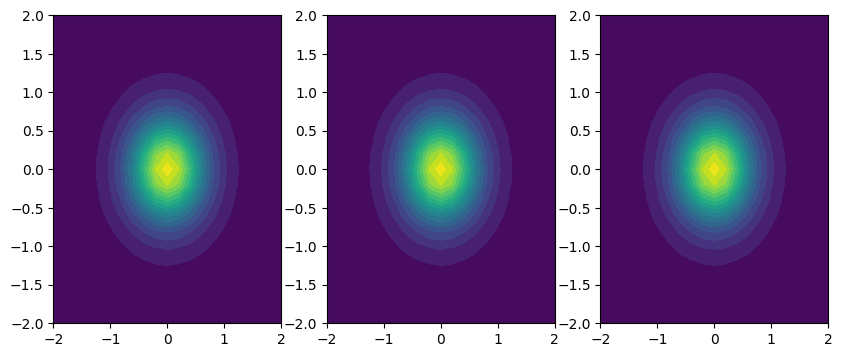

In [14]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# B = 2 Rational Map

In [15]:
Rmap_Num = z**2
Rmap_Den = 1

RationalMap_Parts(Rmap_Num, Rmap_Den)

In [16]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

C:\Users\huido\AppData\Local\Temp\ipykernel_14260\2569610222.py:19: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  idx, idy, idz = np.where(Denom == 0)


In [17]:
# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  1.961849 E =  4.037758


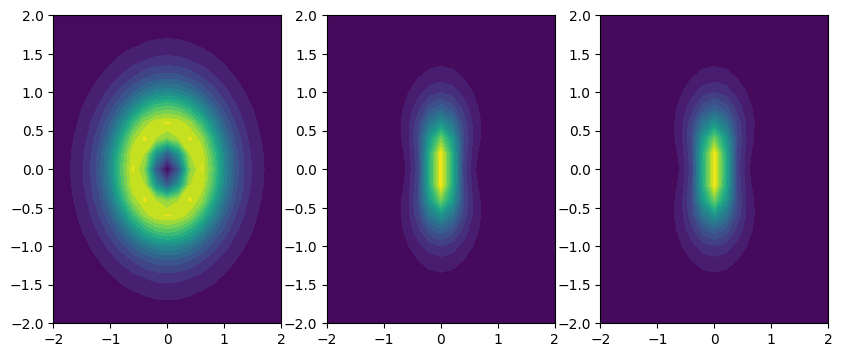

In [18]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# B = 3 Rational Map

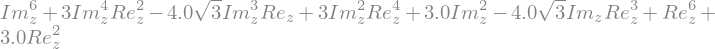

In [19]:
a = 1j

Rmap_Num = sp.sqrt(3)*a*z**2 - 1
Rmap_Den = z*(z**2 - sp.sqrt(3)*a)

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

In [20]:
R_Re

In [21]:
R_Im

In [22]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  2.875296 E =  7.028317


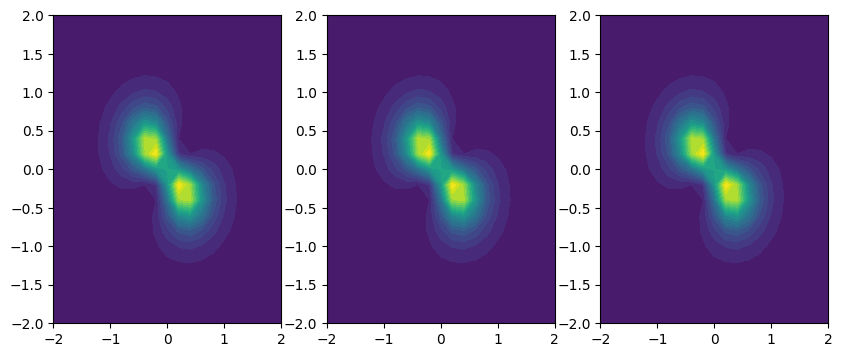

In [23]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# B = 4 Rational Map

In [24]:
# Define the rational map ansatz
Rmap_Num = z**4 + 2*sp.sqrt(3)*sp.I*z**2 + 1
Rmap_Den = z**4 - 2*sp.sqrt(3)*sp.I*z**2 + 1

Rmap_Num

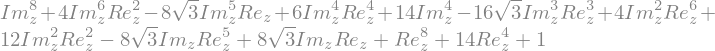

In [25]:
Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

In [26]:
R_Re

In [27]:
R_Im

In [28]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  3.803287 E =  10.401323


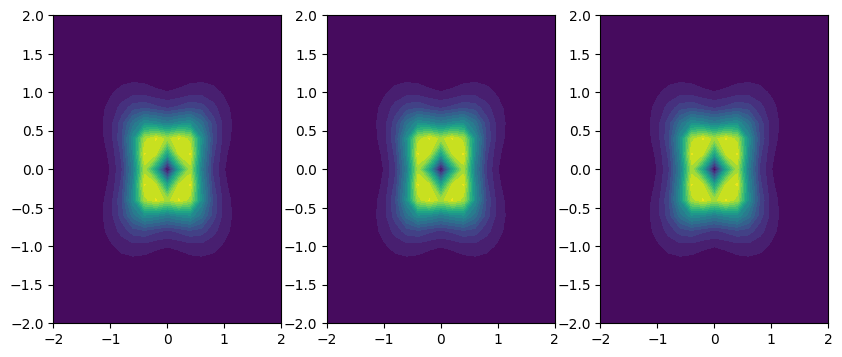

In [29]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# B = 5 Rational Map

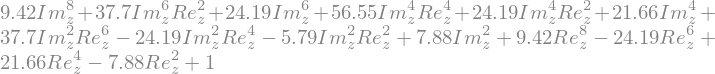

In [30]:
a = 3.07
b = 3.94

Rmap_Num = z*(z**4 + b*z**2 + a)
Rmap_Den = a*z**4 - b*z**2 + 1

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

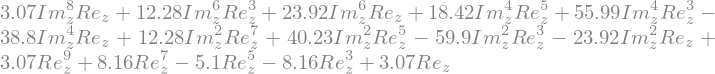

In [31]:
R_Re

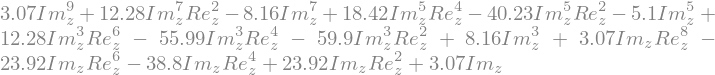

In [32]:
R_Im

In [33]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  4.657179 E =  14.300843


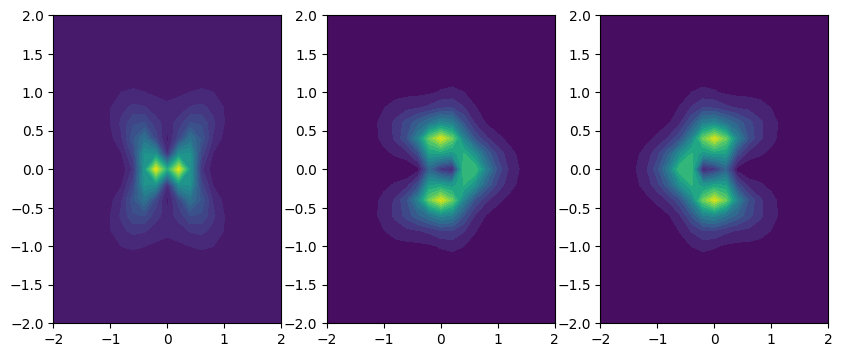

In [34]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# The correct (in quantum states) B = 5

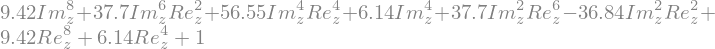

In [35]:
a = 3.07

Rmap_Num = z*(z**4 + a)
Rmap_Den = a*z**4 + 1

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

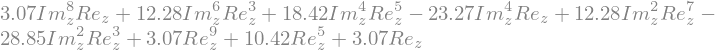

In [36]:
R_Re

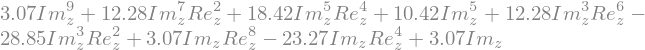

In [37]:
R_Im

In [38]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  4.210724 E =  16.124373


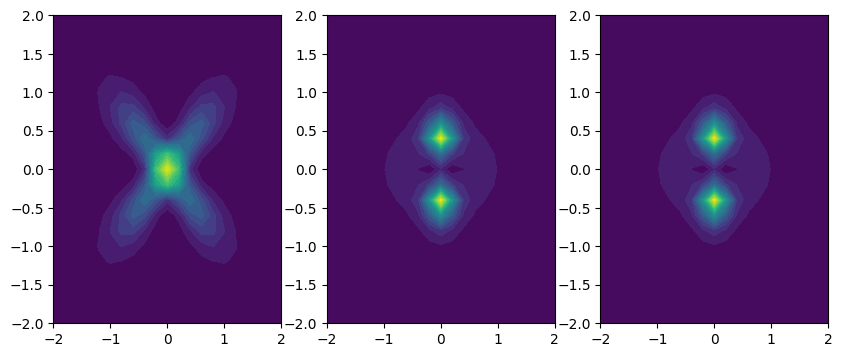

In [39]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# B = 6 Rational Map

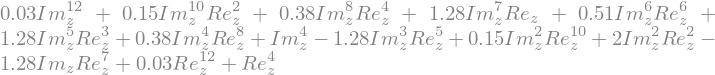

In [40]:
a = 0.16

Rmap_Num = z**4 + sp.I*a
Rmap_Den = z**2*(sp.I*a*z**4 + 1)

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

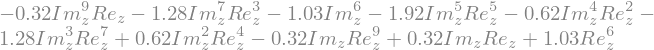

In [41]:
R_Re

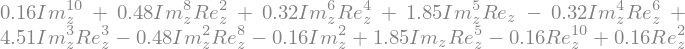

In [42]:
R_Im

In [43]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  5.416195 E =  18.140415


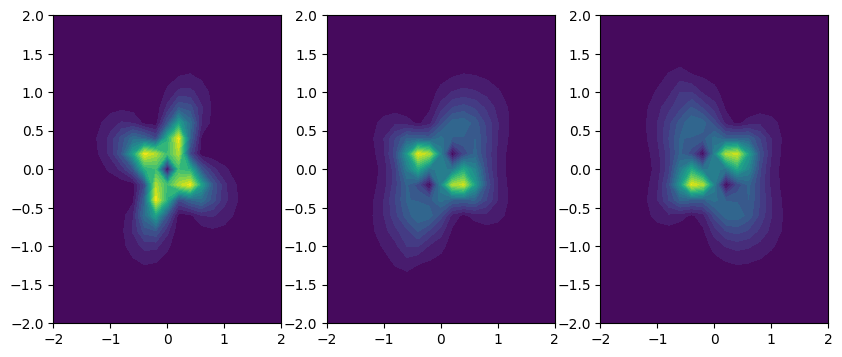

In [44]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# B = 7 Rational Map

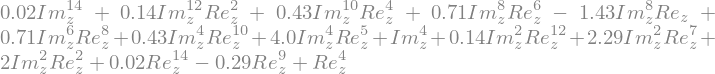

In [45]:
a = -1/7

Rmap_Num = z**5 - a
Rmap_Den = z**2*(a*z**5 + 1)

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

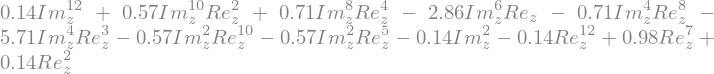

In [46]:
R_Re

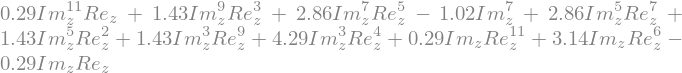

In [47]:
R_Im

In [48]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  6.33329 E =  21.89545


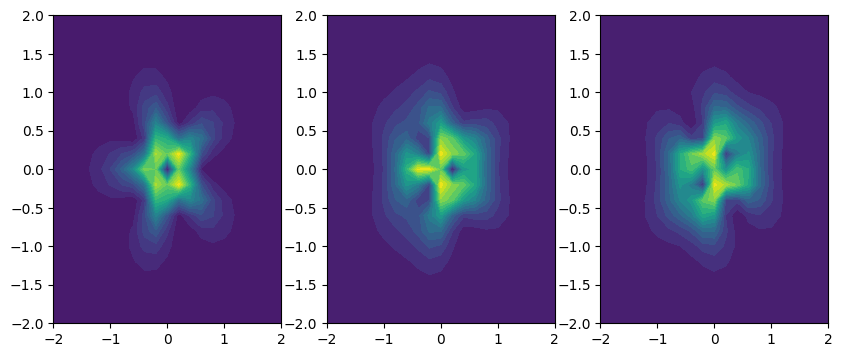

In [49]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# The correct (in quantum states) B = 7

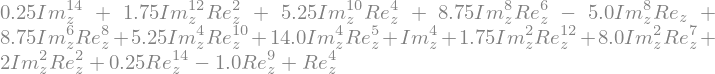

In [50]:
a = -0.5

Rmap_Num = z**5 - a
Rmap_Den = z**2*(a*z**5 + 1)

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

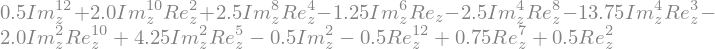

In [51]:
R_Re

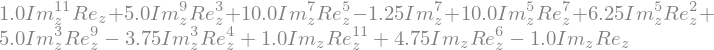

In [52]:
R_Im

In [53]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  5.626305 E =  23.596025


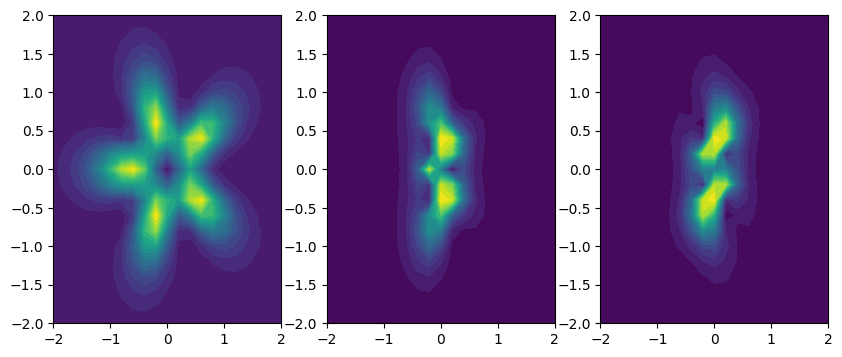

In [54]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# B = 8 Rational Map

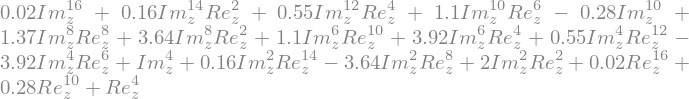

In [55]:
a = 0.14

Rmap_Num = z**6 - a
Rmap_Den = z**2*(a*z**6 + 1)

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

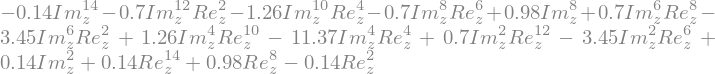

In [56]:
R_Re

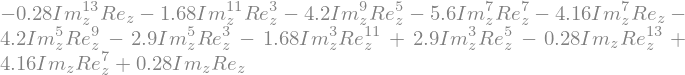

In [57]:
R_Im

In [58]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  6.860094 E =  27.530204


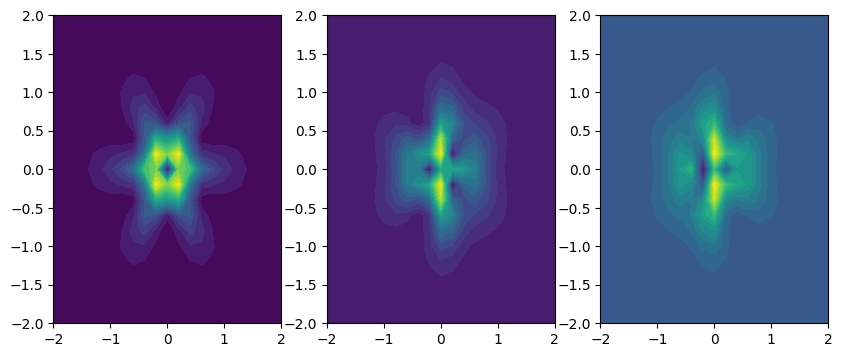

In [59]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()

# Chain B = 8

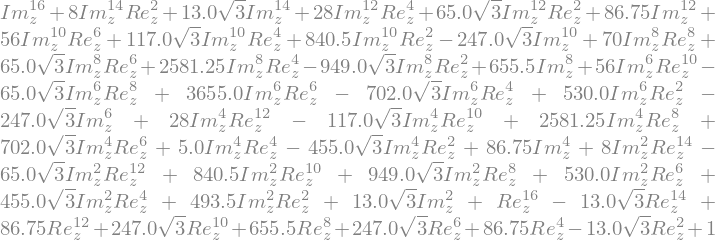

In [60]:
a = 13/2*sp.sqrt(3)
b = 20

Rmap_Num = z**8 + a*z**6 - b*z**4 + a*z**2 + 1
Rmap_Den = z**8 - a*z**6 - b*z**4 - a*z**2 + 1

Denom, R_Re, R_Im = RationalMap_Parts(Rmap_Num, Rmap_Den)

Denom

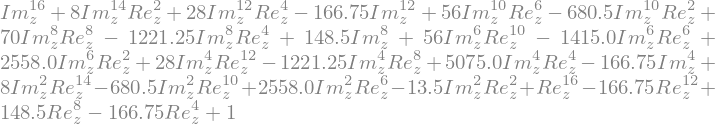

In [61]:
R_Re

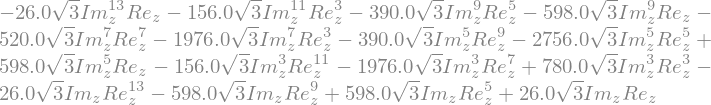

In [62]:
R_Im

In [63]:
# Construct the field configuration
phi = RationalMap(x, Rmap_Num, Rmap_Den)

# Compute the densities
B0 = BaryonDensity(phi)
ED = EnergyDensity(phi)

# Integrate the densities
B = np.sum(B0)*dx**3
E = np.sum(ED)*dx**3
print('B = ', np.round(B, 6), 'E = ', np.round(E, 6))

B =  6.914145 E =  26.985995


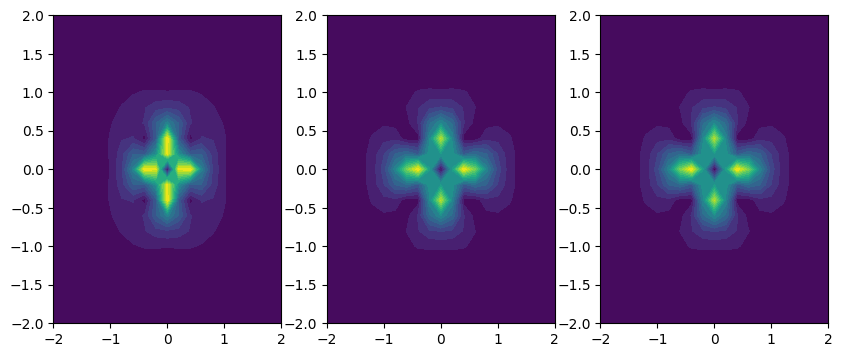

In [64]:
# Plot the densities
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(x[2:-2], x[2:-2], B0[:, :, N//2], levels = 20)
ax2.contourf(x[2:-2], x[2:-2], B0[:, N//2, :], levels = 20)
ax3.contourf(x[2:-2], x[2:-2], B0[N//2, :, :], levels = 20)

ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)

plt.show()